# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [7]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rohitbohra2994","key":"b7947860e2ad40758c4dac7cbd51c8ff"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d snap/amazon-fine-food-reviews

!ls

 97% 244M/251M [00:01<00:00, 134MB/s]
100% 251M/251M [00:01<00:00, 132MB/s]
amazon-fine-food-reviews.zip  database.sqlite  kaggle.json  sample_data


In [12]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
replace Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Reviews.csv             y

replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: database.sqlite         y

replace hashes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: hashes.txt              


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [116]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [118]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [119]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [120]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [121]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [123]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [124]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [125]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [127]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [128]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [129]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [130]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [132]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [133]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [134]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [136]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:36<00:00, 2333.91it/s]


In [137]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [138]:
## Similartly you can do preprocessing for review summary also.

from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 364171/364171 [01:41<00:00, 3599.73it/s]


In [0]:
preprocessed_merged_data=[m+' '+str(n) for m,n in zip(preprocessed_summary,preprocessed_reviews)]

In [140]:
final['CleanedText']=preprocessed_merged_data
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,every book educational witty little book makes...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",love book miss hard cover version grew reading...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup rice months fun way children lear...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,good swingy rhythm reading aloud great little ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,great way learn months book poetry months year...


# [4] Featurization

## [4.1] BAG OF WORDS

In [141]:
# Random sampling 
data = final.take(np.random.permutation(len(final))[:5000])
data.shape

(5000, 11)

In [108]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(data['CleanedText'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(data['CleanedText'])

from sklearn import preprocessing
#Normalize Data
final_counts = preprocessing.normalize(final_counts)

print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaaaa', 'aaaaaaaaaaa', 'aadults', 'aafco', 'aah', 'aarp', 'aback', 'abaloo', 'abandoned']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 15266)
the number of unique words  15266


## [4.2] Bi-Grams and n-Grams.

In [109]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(data['CleanedText'])
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 3489)
the number of unique words including both unigrams and bigrams  3489


## [4.3] TF-IDF

In [110]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(data['CleanedText'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(data['CleanedText'])
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able buy', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves', 'absolutely no']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 3489)
the number of unique words including both unigrams and bigrams  3489


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your train text corpus
i=0
list_of_sentance=[]
for sentance in data['CleanedText']:
    list_of_sentance.append(sentance.split())

In [143]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9739527702331543), ('good', 0.9628058671951294), ('fresh', 0.959476113319397), ('wonderful', 0.9566134810447693), ('coffe', 0.9564678072929382), ('value', 0.9555482864379883), ('starbucks', 0.9550144076347351), ('delish', 0.9548632502555847), ('quite', 0.9547649025917053), ('beans', 0.9531708359718323)]
[('absolute', 0.9985183477401733), ('earth', 0.9984011650085449), ('eaten', 0.9982211589813232), ('major', 0.9981879591941833), ('poured', 0.9981176257133484), ('mustard', 0.9981075525283813), ('waffles', 0.9980950951576233), ('hooked', 0.9980922937393188), ('hands', 0.9980692267417908), ('style', 0.9980557560920715)]


In [146]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4297
sample words  ['messy', 'plastic', 'cap', 'costs', 'make', 'sell', 'big', 'used', 'times', 'different', 'original', 'k', 'cups', 'bit', 'pain', 'clean', 'not', 'brewed', 'right', 'away', 'hole', 'allows', 'air', 'coffee', 'ruin', 'taste', 'stored', 'time', 'also', 'tip', 'place', 'piece', 'tape', 'another', 'annoying', 'step', 'convenience', 'cup', 'going', 'back', 'available', 'want', 'grind', 'quicker', 'less', 'mess', 'use', 'french', 'press', 'instant']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [147]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:05<00:00, 904.10it/s]


5000
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(data['CleanedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [149]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [01:07<00:00, 74.30it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [39]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_jobs=-1,verbose=1).fit(final_counts)
    loss.append(kmeans.inertia_)

Initialization complete
Iteration  0, inertia 182928.321
Iteration  1, inertia 92844.432
Iteration  2, inertia 92675.477
Iteration  3, inertia 92391.226
Iteration  4, inertia 92267.602
Iteration  5, inertia 92249.441
Iteration  6, inertia 92245.433
Iteration  7, inertia 92244.013
Iteration  8, inertia 92243.454
Iteration  9, inertia 92243.215
Iteration 10, inertia 92243.118
Iteration 11, inertia 92243.077
Iteration 12, inertia 92243.053
Iteration 13, inertia 92243.038
Iteration 14, inertia 92243.029
Iteration 15, inertia 92243.026
Iteration 16, inertia 92243.025
Iteration 17, inertia 92243.025
Iteration 18, inertia 92243.025
Converged at iteration 18: center shift 8.742671e-10 within tolerance 1.481077e-09
Initialization complete
Iteration  0, inertia 177561.326
Iteration  1, inertia 93190.590
Iteration  2, inertia 92405.000
Iteration  3, inertia 92268.049
Iteration  4, inertia 92249.106
Iteration  5, inertia 92245.347
Iteration  6, inertia 92244.047
Iteration  7, inertia 92243.486
Ite

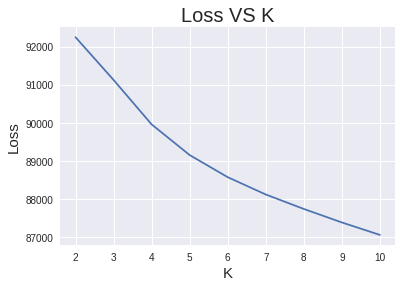

In [40]:
#Draw Loss VS K values plot
plt.plot(k, loss)
plt.xlabel('K',size=15)
plt.ylabel('Loss',size=15)
plt.title('Loss VS K',size=20)
plt.grid(True)
plt.show()

In [0]:
optimal_k = 4

k_means = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(final_counts)

In [53]:
reviews = data['CleanedText'].values

#Getting all the reviews in different clusters
cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(k_means.labels_.shape[0]):
    if k_means.labels_[i] == 0:
        cluster_0.append(reviews[i])
    elif k_means.labels_[i] == 1:
        cluster_1.append(reviews[i])
    elif k_means.labels_[i] == 2:
        cluster_2.append(reviews[i])
    else :
        cluster_3.append(reviews[i]) 
        
#Number of reviews in different clusters
print("No. of reviews in Cluster-0 : ",len(cluster_0))
print("\nNo. of reviews in Cluster-1 : ",len(cluster_1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster_2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster_3))

No. of reviews in Cluster-0 :  51086

No. of reviews in Cluster-1 :  6116

No. of reviews in Cluster-2 :  35391

No. of reviews in Cluster-3 :  7407


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

Cluster 0:

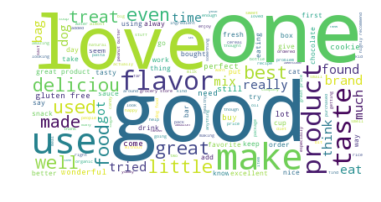

Cluster 1:

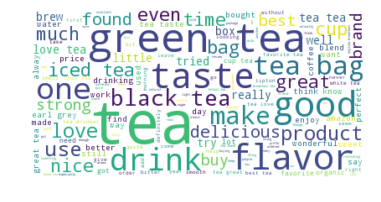

Cluster 2:

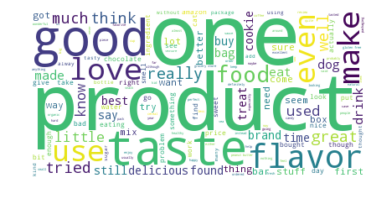

Cluster 3:

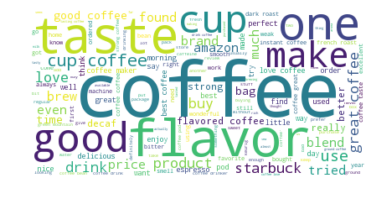

In [54]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

list= [cluster_0, cluster_1, cluster_2, cluster_3]

count=1
for i in range(4):
    print("Cluster %d:" % i, end='')
    count +=1
    wc = WordCloud(background_color="white", max_words=150)
    wc.generate(str(list[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [47]:
from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k:
    kmeans = KMeans(n_clusters=i, init = 'k-means++', n_jobs=-1,verbose=1).fit(final_tf_idf)
    loss.append(kmeans.inertia_)

Initialization complete
Iteration  0, inertia 195948.283
Iteration  1, inertia 98744.785
Iteration  2, inertia 98633.293
Iteration  3, inertia 98538.489
Iteration  4, inertia 98517.385
Iteration  5, inertia 98515.270
Iteration  6, inertia 98514.938
Iteration  7, inertia 98514.865
Iteration  8, inertia 98514.846
Iteration  9, inertia 98514.840
Iteration 10, inertia 98514.838
Iteration 11, inertia 98514.837
Iteration 12, inertia 98514.836
Iteration 13, inertia 98514.836
Iteration 14, inertia 98514.836
Converged at iteration 14: center shift 0.000000e+00 within tolerance 1.594933e-09
Initialization complete
Iteration  0, inertia 194112.894
Iteration  1, inertia 98728.464
Iteration  2, inertia 98684.692
Iteration  3, inertia 98671.023
Iteration  4, inertia 98654.515
Iteration  5, inertia 98631.747
Iteration  6, inertia 98601.709
Iteration  7, inertia 98563.258
Iteration  8, inertia 98526.937
Iteration  9, inertia 98516.214
Iteration 10, inertia 98515.090
Iteration 11, inertia 98514.903
Ite

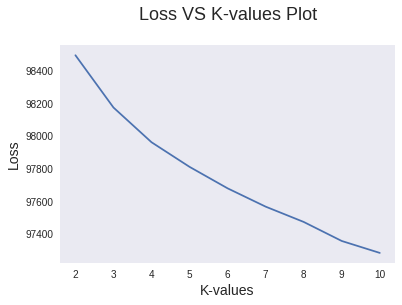

In [51]:
#Draw Loss VS K values plot
plt.plot(k, loss)
plt.xlabel('K',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [0]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(final_tf_idf)

In [57]:
reviews = data['CleanedText'].values

#Getting all the reviews in different clusters
cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_0.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_1.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster_2.append(reviews[i])
    else :
        cluster_3.append(reviews[i]) 
        
#Number of reviews in different clusters
print("No. of reviews in Cluster-0 : ",len(cluster_0))
print("\nNo. of reviews in Cluster-1 : ",len(cluster_1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster_2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster_3))

No. of reviews in Cluster-0 :  6289

No. of reviews in Cluster-1 :  7976

No. of reviews in Cluster-2 :  77736

No. of reviews in Cluster-3 :  7999


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

Cluster 0:

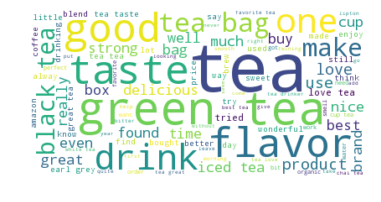

Cluster 1:

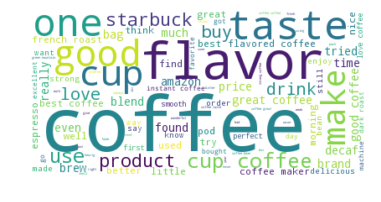

Cluster 2:

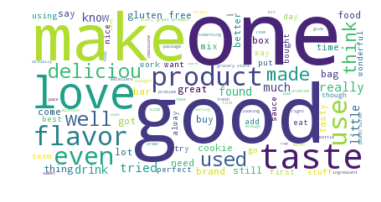

Cluster 3:

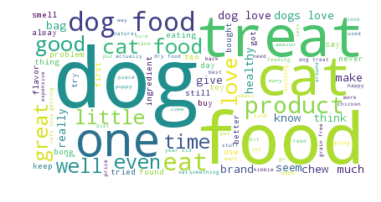

In [58]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

list= [cluster_0, cluster_1, cluster_2, cluster_3]

count=1
for i in range(4):
    print("Cluster %d:" % i, end='')
    count +=1
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate(str(list[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k:
    kmeans = KMeans(n_clusters=i, init = 'k-means++', n_jobs=-1).fit(sent_vectors)
    loss.append(kmeans.inertia_)


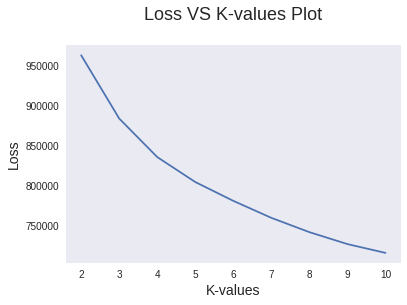

In [47]:
#Draw Loss VS K values plot
plt.plot(k, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K Plot\n',size=18)
plt.grid()
plt.show()


In [0]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(sent_vectors)

In [52]:
reviews = data['CleanedText'].values

#Getting all the reviews in different clusters
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster0.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster2.append(reviews[i])
    else :
        cluster3.append(reviews[i]) 
        
#Number of reviews in different clusters
print("No. of reviews in Cluster-0 : ",len(cluster0))
print("\nNo. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-0 :  39026

No. of reviews in Cluster-1 :  43775

No. of reviews in Cluster-2 :  17199


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

Cluster 0:

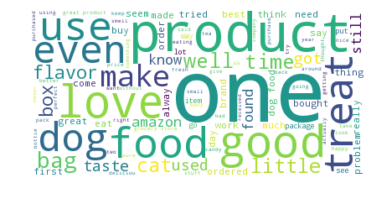

Cluster 1:

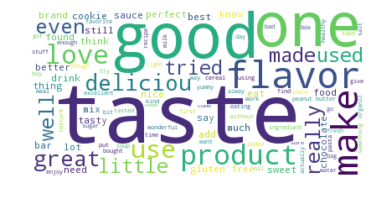

Cluster 2:

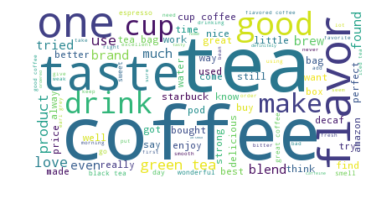

In [54]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

list= [cluster0, cluster1, cluster2, cluster3]

count=1
for i in range(3):
    print("Cluster %d:" % i, end='')
    count +=1
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate(str(list[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k:
    kmeans = KMeans(n_clusters=i, init = 'k-means++', n_jobs=-1).fit(tfidf_sent_vectors)
    loss.append(kmeans.inertia_)

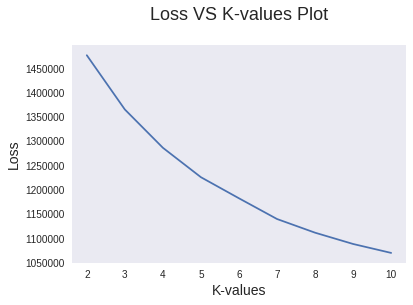

In [56]:
#Draw Loss VS K values plot
plt.plot(k, loss)
plt.xlabel('K',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K Plot\n',size=18)
plt.grid()
plt.show()

In [0]:
optimal_k = 5

kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(tfidf_sent_vectors)

In [59]:
reviews = data['CleanedText'].values

#Getting all the reviews in different clusters
cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []


for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_0.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_1.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster_2.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster_3.append(reviews[i])    
    else :
        cluster_4.append(reviews[i]) 
        
#Number of reviews in different clusters
print("No. of reviews in Cluster-0 : ",len(cluster0))
print("\nNo. of reviews in Cluster-1 : ",len(cluster_1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster_2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster_3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster_4))

No. of reviews in Cluster-0 :  27911

No. of reviews in Cluster-1 :  31477

No. of reviews in Cluster-2 :  17117

No. of reviews in Cluster-3 :  13623

No. of reviews in Cluster-4 :  9872


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

Cluster 0:

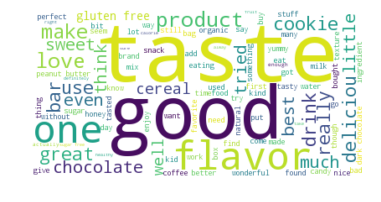

Cluster 1:

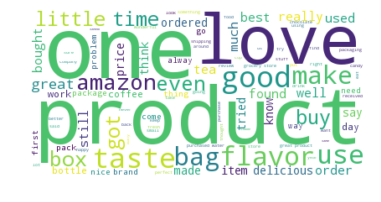

Cluster 2:

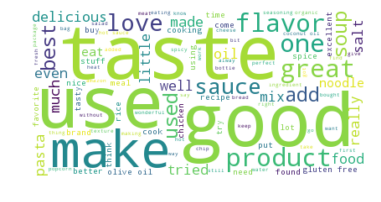

Cluster 3:

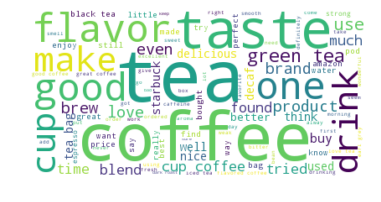

Cluster 4:

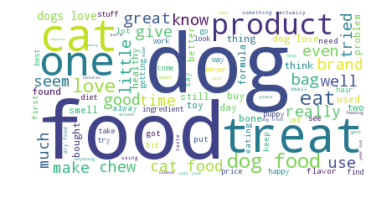

In [60]:
list= [cluster_0, cluster_1, cluster_2, cluster_3,cluster_4]

count=1
for i in range(5):
    print("Cluster %d:" % i, end='')
    count +=1
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate(str(list[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5).fit(sent_vectors)

In [159]:
reviews = data['CleanedText'].values

#Getting all the reviews in different clusters
cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_0.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster_1.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster_2.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster_3.append(reviews[i])
    else :
        cluster_4.append(reviews[i]) 
        
#Number of reviews in different clusters
print("No. of reviews in Cluster-0 : ",len(cluster_0))
print("\nNo. of reviews in Cluster-1 : ",len(cluster_1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster_2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster_3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster_4))

No. of reviews in Cluster-0 :  981

No. of reviews in Cluster-1 :  1319

No. of reviews in Cluster-2 :  1628

No. of reviews in Cluster-3 :  768

No. of reviews in Cluster-4 :  304


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

Cluster 0:

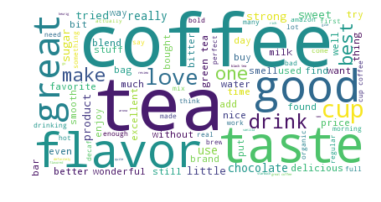

Cluster 1:

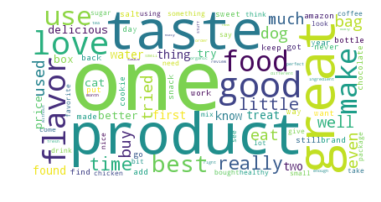

Cluster 2:

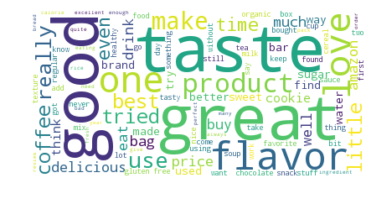

Cluster 3:

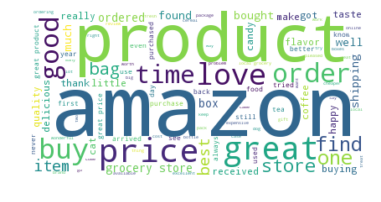

Cluster 4:

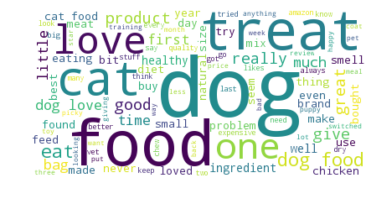

In [160]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
list= [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4]

count=1
for i in range(5):
    print("Cluster %d:" % i, end='')
    count +=1
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate(str(list[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5).fit(tfidf_sent_vectors)

In [162]:
reviews = data['CleanedText'].values

#Getting all the reviews in different clusters
cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_0.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster_1.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster_2.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster_3.append(reviews[i])
    else :
        cluster_4.append(reviews[i]) 
        
#Number of reviews in different clusters
print("No. of reviews in Cluster-0 : ",len(cluster_0))
print("\nNo. of reviews in Cluster-1 : ",len(cluster_1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster_2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster_3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster_4))

No. of reviews in Cluster-0 :  1948

No. of reviews in Cluster-1 :  971

No. of reviews in Cluster-2 :  1556

No. of reviews in Cluster-3 :  255

No. of reviews in Cluster-4 :  270


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

Cluster 0:

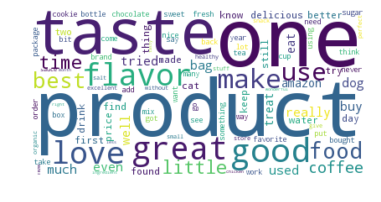

Cluster 1:

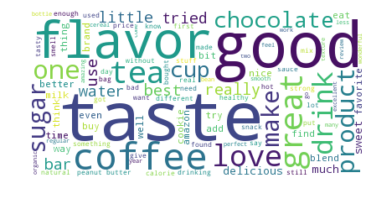

Cluster 2:

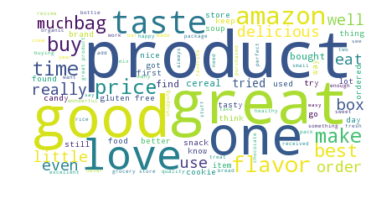

Cluster 3:

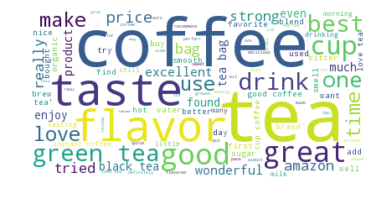

Cluster 4:

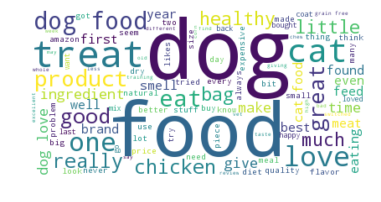

In [163]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
list= [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4]

count=1
for i in range(5):
    print("Cluster %d:" % i, end='')
    count +=1
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate(str(list[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [0]:
#Function to determinethe distance of nth-nearest neighbour 
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))

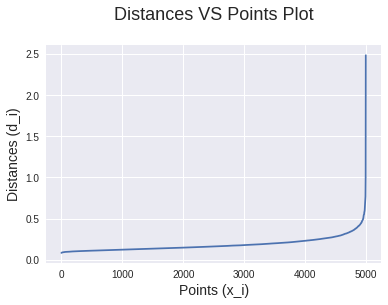

In [177]:
min_points = 2*data.shape[1]

#Computing distances
distances = n_neighbour(sent_vectors,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

#Plot distances vs points
plt.plot(points, sorted_distance)
plt.xlabel('Points ',size=14)
plt.ylabel('Distances ',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid(True)
plt.show()

In [178]:
from sklearn.cluster import DBSCAN
#Training DBSCAN :
db = DBSCAN(eps = 0.25, min_samples = min_points, n_jobs=-1)
db.fit(sent_vectors)

n_clusters = len(set(db.labels_))
print("Number of clusters is : %d "%(n_clusters))

Number of clusters is : 2 


In [0]:
model = db.fit_predict(sent_vectors)

In [180]:
reviews = data['CleanedText'].values

#Getting all the reviews in different clusters
cluster_0 = []
cluster_1 = []

for i in range(db.labels_.shape[0]):
    if db.labels_[i] == 0:
        cluster_0.append(reviews[i])
    else :
        cluster_1.append(reviews[i]) 
        
#Number of reviews in different clusters
print("No. of reviews in Cluster-0 : ",len(cluster_0))
print("\nNo. of reviews in Cluster-1 : ",len(cluster_1))


No. of reviews in Cluster-0 :  4733

No. of reviews in Cluster-1 :  267


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

Cluster 0:

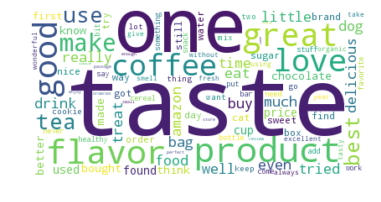

Cluster 1:

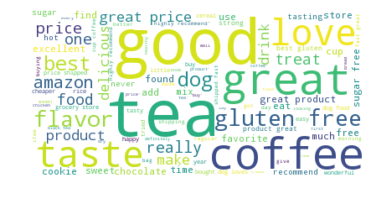

In [183]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
list= [cluster_0, cluster_1]

count=1
for i in range(2):
    print("Cluster %d:" % i, end='')
    count +=1
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate(str(list[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

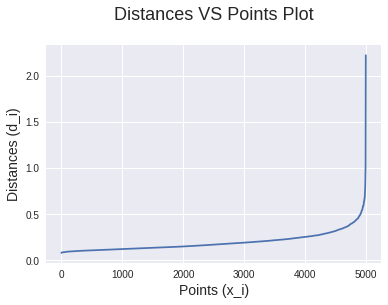

In [184]:
min_points = 2*data.shape[1]

#Computing distances of nth-nearest neighbours
distances = n_neighbour(tfidf_sent_vectors,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

#Plot distances vs points
plt.plot(points, sorted_distance)
plt.xlabel('Points ',size=14)
plt.ylabel('Distances ',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid(True)
plt.show()

In [185]:
#Training DBSCAN :
db = DBSCAN(eps = 0.3, min_samples = min_points, n_jobs=-1)
db.fit(tfidf_sent_vectors)

n_clusters = len(set(db.labels_))
print("Number of clusters is : %d "%(n_clusters))

Number of clusters is : 2 


In [0]:
model = db.fit_predict(tfidf_sent_vectors)


In [187]:
reviews = data['CleanedText'].values

#Getting all the reviews in different clusters
cluster_0 = []
cluster_1 = []

for i in range(db.labels_.shape[0]):
    if db.labels_[i] == 0:
        cluster_0.append(reviews[i])
    else :
        cluster_1.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-0 : ",len(cluster_0))
print("\nNo. of reviews in Cluster-1 : ",len(cluster_1))

No. of reviews in Cluster-0 :  4792

No. of reviews in Cluster-1 :  208


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

Cluster 0:

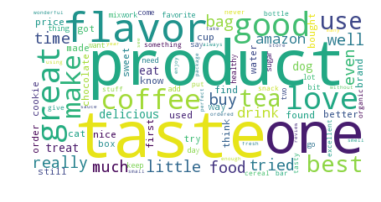

Cluster 1:

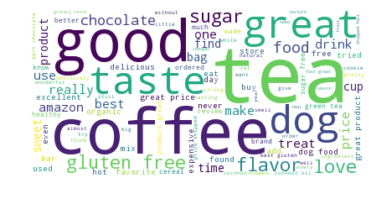

In [188]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
list= [cluster_0, cluster_1]

count=1
for i in range(2):
    print("Cluster %d:" % i, end='')
    count +=1
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate(str(list[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

##### The number of data taken is 100000 for k means, 5000 for agglomerative clustering and 5000 for DBSCAN

# [6] Conclusions

In [2]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["Featurization technique", "No. of Clusters"]
x.add_row(["BOW", 4])
x.add_row(["TF-IDF", 4])
x.add_row(["Avg-W2V",  3])
x.add_row(["TF-IDF-W2V", 5])

print('\tKmeans technique')
print(x)

	Kmeans technique
+-------------------------+-----------------+
| Featurization technique | No. of Clusters |
+-------------------------+-----------------+
|           BOW           |        4        |
|          TF-IDF         |        4        |
|         Avg-W2V         |        3        |
|        TF-IDF-W2V       |        5        |
+-------------------------+-----------------+


In [3]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["Featurization technique", "No. of Clusters"]


x.add_row(["Avg-W2V",  5])
x.add_row(["TF-IDF-W2V", 5])

print('\t Agglomerative Clustering technique')
print(x)

	 Agglomerative Clustering technique
+-------------------------+-----------------+
| Featurization technique | No. of Clusters |
+-------------------------+-----------------+
|         Avg-W2V         |        5        |
|        TF-IDF-W2V       |        5        |
+-------------------------+-----------------+


In [5]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["Featurization technique", "Epsilon", "No. of Clusters"]

x.add_row(["Avg-W2V", 0.25, 2])
x.add_row(["TFIDF-W2V", 0.3, 2])

print('\tDBSCAN Clustering technique')
print(x)

	DBSCAN Clustering technique
+-------------------------+---------+-----------------+
| Featurization technique | Epsilon | No. of Clusters |
+-------------------------+---------+-----------------+
|         Avg-W2V         |   0.25  |        2        |
|        TFIDF-W2V        |   0.3   |        2        |
+-------------------------+---------+-----------------+


# WordCloud Observation

#### k-means :
1) BOW - 
     1) The wordcloud mostly has words which are positively related to taste like delicious, good, flavour, love etc.
     
     2) The wordcloud mostly has words which are positively about tea like green, tea, black, good, etc.
     
     3) The wordcloud mostly has words which are positively talking about product like good, product, taste, flavour, etc.
     
     4) The wordcloud mostly has words which are positively talking about coffee like taste, coffee, flavour, good, etc.
  
2) TF-IDF - 
     1) The wordcloud mostly has words which are positively talking about tea like good, tea, green, taste, flavour.
     
     2) The wordcloud mostly has words which are positively talking about coffee like good, flavour, cofee, cup, etc.
     
     3) The wordcloud mostly has words which are positively talking about product like good, product, good, taste, etc.
     
     4) The wordcloud mostly has words which are positively talking about dog & cat food like great, food, cat, dog, product, etc.
     
3) Average Word2Vec -
     1) The wordcloud mostly has words which are positively talking about dog and cat food like product, good, food, dog, cat, etc.
    
     2) The wordcloud mostly has words which are positively talking about taste like taste, good, flavour, delicious, etc.
     3) The wordcloud mostly has words which are positively talking about tea & coffee like taste, tea, coffee, flavour, good, etc.
   
4) TF-IDF Word2Vec -
     1) The wordcloud mostly has words which are positively talking about some snack like taste, good, flavour, chocolate, cereal, cookie, etc.
     
     2) The wordcloud mostly has words which are positively talking about taste like love, product, one, flavour, etc.
     
     3) The wordcloud mostly has words which are positively talking about soap like good, taste, use, make, soap, sauce, etc.
     
     4) The wordcloud mostly has words which are positively talking about tea & coffee like taste, tea, coffee, flavour, good, green etc.
     
     5) The wordcloud mostly has words which are positively talking about dog & cat food like great, food, cat, dog, product, etc.
  
#### Agglomerative clustering :
1) Average Word2Vec - 
     1) The wordcloud mostly has words which are positively talking about tea & coffee like taste, tea, coffee, flavour, good etc.
     
     2) The wordcloud mostly has words which are positively talking about taste like great, taste, good, flavour, delicious, etc.
     
     3) The wordcloud mostly has words which are positively talking about coffee like good, flavour, delicious, taste, coffee, etc.
     
     4) The wordcloud mostly has words which are positively talking about amazon like time, good, amazon, order, store, etc.
     
     5) The wordcloud mostly has words which are positively talking about dog and cat food like product, good, food, dog, cat, etc.
   
2) TF-IDF Word2Vec -
     1) The wordcloud mostly has words which are positively talking about product like great, taste, good, flavour, food, etc.
     
     2) The wordcloud mostly has words which are positively talking about tea & coffee like taste, tea, coffee, flavour, good etc.
     
     3) The wordcloud mostly has words which are positively talking about amazon like time, good, amazon, order, store, etc.
     
     4) The wordcloud mostly has words which are positively talking about tea & coffee like taste, tea, coffee, flavour, good, green etc.
     
     5) The wordcloud mostly has words which are positively talking about dog and cat food like product, good, food, dog, cat, healthy etc.
     
#### DBSCAN Clustering :
1) Average Word2Vec - 
     1) The wordcloud mostly has words which are positively talking about tea & coffee like taste, tea, coffee, flavour, good, great etc.
     
     2) The wordcloud mostly has words which are positively talking about tea & coffee like good, great, love, gluten, good, free etc.
    
2) TF-IDF Word2Vec -
     1) The wordcloud mostly has words which are positively talking about tea & coffee like good, great, love, gluten, good, free etc.
     
     2) The wordcloud mostly has words which are positively talking about tea & coffee like good, taste, coffee, sugar etc.